In [1]:
import pandas as pd
import numpy as np
df_train = pd.read_csv("./Review_train.csv")
df_train.head()

,Unnamed: 0,Score,Text
0,185797,3,product grainy expect shipping cost line send ...
1,77873,3,switch black cherry soda fine drink enjoy carb...
2,70612,4,really like nana cookie place several order pe...
3,3830,5,first see product panda licorice memphis tn zo...
4,19710,5,baby food convenient healthy great worry son e...


In [2]:
#import wget
#url = "http://nlp.stanford.edu/data/glove.6B.zip"
#path="./glove/"
#filename = wget.download(url, out=path)

In [3]:
#import zipfile
#with zipfile.ZipFile(filename, "r") as fzip:
 #   fzip.extractall(path)

In [4]:
embeddings_index = {}
with open("./glove/glove.6B.50d.txt", encoding='utf8') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        vector = np.fromstring(vector, "f", sep=" ")
        embeddings_index[word] = vector

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [5]:
df_val = pd.read_csv("./Review_val.csv")
df_val.head()

,Unnamed: 0,Score,Text
0,38917,5,always like thing screamin demon usually grab ...
1,112495,4,like cracker good little fil
2,224039,3,green habanero sauce quite potent two three dr...
3,330772,2,try find high protein alternative snack figure...
4,307183,3,get wasabi soy flavor week ago taste right las...


In [6]:
df_test = pd.read_csv("./Review_test.csv")
df_test.head()

,Unnamed: 0,Score,Text
0,529973,2,really want cat like food especially consider ...
1,306459,1,dog love food see amazon prime eligible figure...
2,40986,5,lily dark chocolate bar clearly make high qual...
3,555243,2,sea gift korean seaweed snack sweet good way p...
4,374672,3,let start say tea drinker since first drink ja...


In [7]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [8]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(vocab_size=10000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
print(trainer)

In [9]:
from tokenizers.pre_tokenizers import Whitespace

tokenizer.pre_tokenizer = Whitespace()

In [10]:
files = [f"./Review_{split}.csv" for split in ["train", "val"]]

tokenizer.train(files, trainer)

In [11]:
tokenizer.save("./tokenizer-review.csv")

In [12]:
import numpy as np
from tokenizers import BertWordPieceTokenizer
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./tokenizer-review.csv")

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result)

In [13]:
vocab = tokenizer.get_vocab()
#print(vocab)

In [14]:
num_tokens = len(vocab) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 8832 words (1168 misses)


In [15]:
import tensorflow as tf

maxlen = 64

X_train = list(df_train["Text"].values)
X_train = bert_tokenizer(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["Score"].values-1

X_val = list(df_val["Text"].values)
X_val = bert_tokenizer(X_val)
y_val = df_val["Score"].values-1
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

X_test = list(df_test["Text"].values)
X_test = bert_tokenizer(X_test)
y_test = df_test["Score"].values-1
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

<ipython-input-12-f38849e7051d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(result)


In [16]:
import tensorflow as tf

emb_size = 64
max_features = 30000 # vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size,  input_length=maxlen),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=5, activation='softmax')
]) 

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 64)            1920000   
_________________________________________________________________
dense (Dense)                (None, 64, 64)            4160      
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 32)            14368     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1

In [17]:
h = model.fit(X_train, 
              y_train,
              epochs=5,
              batch_size=32,
              validation_data=(X_val, y_val))

Epoch 1/5
2326/2326 [==============================] - 44s 19ms/step - loss: 1.3907 - accuracy: 0.3781 - val_loss: 1.2402 - val_accuracy: 0.4709
Epoch 2/5
2326/2326 [==============================] - 43s 18ms/step - loss: 1.0811 - accuracy: 0.5515 - val_loss: 1.2325 - val_accuracy: 0.4870
Epoch 3/5
2326/2326 [==============================] - 43s 19ms/step - loss: 0.9178 - accuracy: 0.6346 - val_loss: 1.2728 - val_accuracy: 0.5008
Epoch 4/5
2326/2326 [==============================] - 43s 19ms/step - loss: 0.7430 - accuracy: 0.7134 - val_loss: 1.3756 - val_accuracy: 0.5088
Epoch 5/5
2326/2326 [==============================] - 45s 20ms/step - loss: 0.5811 - accuracy: 0.7836 - val_loss: 1.5500 - val_accuracy: 0.5125


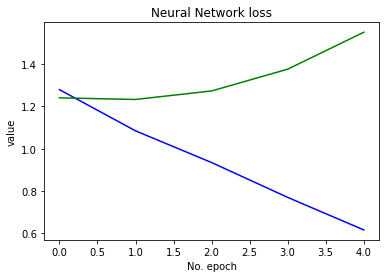

In [18]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

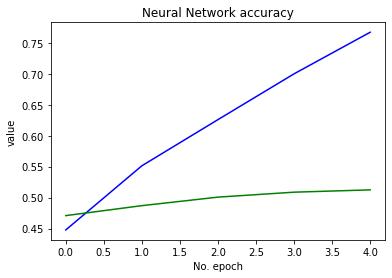

In [19]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [20]:
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

776/776 [==============================] - 1s 2ms/step - loss: 1.5432 - accuracy: 0.5182
test loss, test acc: [1.5432204008102417, 0.5181616544723511]


In [21]:
df_test_raw = pd.read_csv("./Review_test.csv")

In [22]:
predictions = np.round(model.predict(X_test[:100]))
for i in range(len(predictions)):
    print(df_test_raw["Text"].values[i][:100],"...")
    print("Pred: ", predictions[i], "Real: ", y_test[i])

really want cat like food especially consider expensive want eat introduce food mix old junk food dr ...
Pred:  [0. 0. 0. 1. 0.] Real:  1
dog love food see amazon prime eligible figure would easy way get food trip pet store sure bag sit h ...
Pred:  [0. 0. 0. 0. 0.] Real:  0
lily dark chocolate bar clearly make high quality chocolate tiny bit dairy sweetener stevia among he ...
Pred:  [0. 0. 0. 1. 0.] Real:  4
sea gift korean seaweed snack sweet good way price get buy ...
Pred:  [0. 0. 0. 0. 0.] Real:  1
let start say tea drinker since first drink jasmine green tea chinese restaurant mom buy bigelow ear ...
Pred:  [1. 0. 0. 0. 0.] Real:  2
product come encase within beautiful lightly brown biodegradable br attention detail astounding make ...
Pred:  [0. 0. 0. 0. 1.] Real:  4
son soy since almost week old due reflux vomit eat early much anymore still get heart burn though li ...
Pred:  [0. 0. 0. 0. 1.] Real:  3
try teriyaki flavour please fairly high salt sodium per oz might normal jerk